# Stochastic Kronecker Graphical Models


In the following, we will write a flow to obtain the process chain to implement our graphical model and generate examples from it.

In [1]:
# All imports
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Methods being used:

In [2]:
def kronecker_product(mat1, mat2):
    m1 = tf.shape(mat1)[0]
    n1 = tf.size(mat1) // m1
    m2 = tf.shape(mat2)[0]
    n2 = tf.size(mat2) // m2
    mat2_rsh =tf.reshape(mat1, [1, m1, 1, n1])
    mat1_rsh =tf.reshape(mat2, [m2, 1, n2, 1])
    return tf.reshape(mat1_rsh*mat2_rsh, [m1 * m2, n1 * n2])

In [3]:
def addNoise2Theta(theta_c, mean=0, std=0.01, NRMLZ=True):
    # Set the seed so the results are reproducible.
    np.random.seed(123)
    # Make distribution, sample and add
    p_eta = tfd.Normal(loc=mean, scale=std, name='AdditiveEdgeNoise')
    eta_c = p_eta.sample(tf.shape(theta_c))
    theta_c_noise = theta_c + eta_c
    # Make sure values do not run off
    # Clip values out of [0,1]
    if NRMLZ:
        theta_c_noise_nrml   = tf.maximum(tf.minimum(theta_c_noise,1),0)
        return theta_c_noise_nrml
    else:
        return theta_c_noise

### Parameters:

In [4]:
theta_shape   = np.array([3,3])
alpha_        = [1.0]
beta_         = [1.0]
K             = 5
NoiseScale    = 0.1

# Run Parameters
NumSamples    = 5

### Process chain:



In [5]:
# Build and generate mu samples for the size of theta_c
alpha  = tf.placeholder_with_default([1.0], [1])
beta   = tf.placeholder_with_default([1.0], [1])
mu_batch_shape   = tf.placeholder(tf.int32)
p_mu   = tfd.Beta(alpha, beta, name='Mu_distb')
mu_batch  = tf.squeeze(p_mu.sample(mu_batch_shape),axis=2)
theta_c   = mu_batch

Use the mu samples as thresholds for theta Bernoulli distributions of edges.

In [6]:
# Use the mu samples as thresholds for 
# theta Bernoulli distributions of edges
theta_c_distb = tfd.Bernoulli(probs=mu_batch, name='theta_c') # Actually never used

Kronecker multiply to obtain the $P_{kc}$

In [7]:
Pk_c   = addNoise2Theta(theta_c)
for i in range(1,K):
    # Add noise to the theta
    itheta_c   =  addNoise2Theta(theta_c, std=NoiseScale)
    # Do kronecker product
    Pk_c   = kronecker_product(Pk_c, itheta_c)

Sample from the $P_{kc}$

In [8]:
Pk_c_distb   = tfd.Bernoulli(probs=Pk_c, name='Pk_c')
G_c          = Pk_c_distb.sample(NumSamples)


### Run and Plot:

In [9]:
sess = tf.Session()
[G, Pk_c_s, theta_c] = sess.run([G_c, Pk_c, mu_batch], 
                                feed_dict={mu_batch_shape:theta_shape,
                                           alpha:alpha_,
                                           beta:beta_
                                          })

In [10]:
print(theta_c)
print(Pk_c_s.shape)
print(G.shape)

[[ 0.6166932   0.85714024  0.9245218 ]
 [ 0.37226883  0.77739257  0.98604167]
 [ 0.91304314  0.1981654   0.93178129]]
(243, 243)
(5, 243, 243)


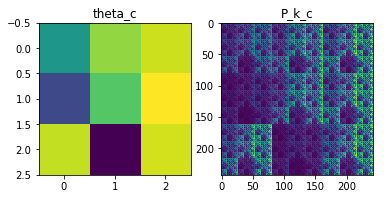

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(theta_c)
plt.title('theta_c')

plt.subplot(1,2,2)
plt.imshow(Pk_c_s)
plt.title('P_k_c')

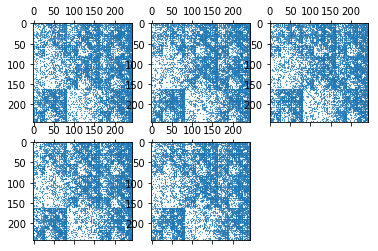

In [17]:
plt.figure()
plt.title('All samples')
r = np.floor(np.sqrt(NumSamples))
c = np.ceil(float(NumSamples)/r)
for i in range(0,NumSamples):
    plt.subplot(r,c,i+1)
    plt.spy(G[i,:], markersize=0.2)